In [11]:
##OBJECTIVE 
##SENTIMENT CLASSIFICATION  FOR IMDB USING LSTM


In [12]:

import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import random
import time
import sys

In [13]:
def get_GPU_CPU(seed_val = 1):
    print('The Seed is set to {}'.format(seed_val))
    if torch.cuda.is_available():
        print('Model will Run on CUDA.')
        torch.cuda.manual_seed(seed_val)
        !nvidia-smi
        device = 'cuda'
    else:
        torch.manual_seed(seed_val)
        print ('Running in CPU')
        device = 'cpu'
    cuda = torch.cuda.is_available()
    return cuda,seed_val,device

In [14]:
cuda,SEED,device = get_GPU_CPU(seed_val=1234)

The Seed is set to 1234
Model will Run on CUDA.
Thu May 27 17:10:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                        

In [15]:
# make your experiment reproducible, similar to set random seed to all options where there needs a random seed
torch.backends.cudnn.deterministic = True

In [16]:
##CHANGE 01 :
#We'll be using packed padded sequences, which will make our RNN only process the non-padded elements of our sequence,
# and for any padded element the output will be a zero tensor. To use packed padded sequences, we have to tell the RNN how long the actual sequences are.
# We do this by setting include_lengths = True for our TEXT field. 
#This will cause batch.text to now be a tuple with the first element being our sentence (a numericalized tensor that has been padded) and the second element being the actual lengths of our sentences.

In [17]:
#here spacy is a tokenizer 
TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)



In [18]:
#WHY FLOAT  FOR LABEL:
# when initializing the LABEL field, we set dtype=torch.float. This is because TorchText sets tensors to be LongTensors by default,
# however our criterion expects both inputs to be FloatTensors. Setting the dtype to be torch.float, did this for us.
# The alternative method of doing this would be to do the conversion inside the train function by passing batch.label.float() 
#instad of batch.label to the criterion.

In [19]:
#DOWNLOAD DATA  AND SPLIT DATA INTO TRAIN AND TEST
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [20]:
#CHECK LENGTH OF TRAIN AND TEST DATA 
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [21]:
#SEE A SAMPLE DATA 
print(vars(train_data.examples[0]))
#This will return a dictionary with key as "text " and "labels"

{'text': ['Who', 'would', "n't", 'want', 'to', 'go', 'on', 'road', 'trip', 'with', 'Peter', 'Falk', '?', 'That', 'guy', "'s", 'right', 'eye', 'has', 'more', 'character', 'than', 'most', 'actors', 'today', '.', 'This', 'is', 'the', 'kind', 'of', 'funny', 'and', 'touching', 'movie', 'we', 'are', 'all', 'looking', 'for', 'as', 'a', 'counterbalance', 'to', 'all', 'the', 'bombastic', 'special', 'effects', 'bores', '.', 'Women', 'are', 'going', 'to', 'love', 'it', 'for', 'all', 'the', 'wake', '-', 'up', 'romance', 'advice', 'for', 'men', ',', 'and', 'men', 'will', 'love', 'it', 'for', 'its', 'spot', '-', 'on', 'father', '/', 'son', 'character', 'study', '--', 'one', 'great', 'little', 'scene', 'after', 'another', '.', 'And', 'it', 'has', 'just', 'enough', 'of', 'an', 'edge', 'to', 'be', 'a', 'true', 'indie', 'find', '.', 'Obviously', 'this', 'is', 'a', 'labor', 'of', 'love', 'for', 'Paul', 'Reiser', 'who', 'understands', 'what', 'it', "'s", 'like', 'to', 'be', 'both', 'a', 'father', 'and', '

In [22]:
#DIVIDE TRAIN  DATA INTO TRAIN AND VAILID IN 80:20 RATIO
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [23]:
# CHECK LENGTH OF TRAIN TEST AND VALID
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [62]:
#Construct the Vocab object for this field from one or more datasets.
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)


#This is basically assigning a unique number to each word . one document may contain 10 lakh element but we should not 
#take 10 lakhs unique index instead take 25000 most repeated word and use them for assigning index to words .
#so What happens if a word encounted which is not in most frequent 25000 in tht case that word is assigned with <unk> i,e unknown 

In [63]:
#Why do we only build the vocabulary on the training set? 
#When testing any machine learning system you do not want to look at the test set in any way. We do not include the validation set as we want it to reflect the test set as much as possible.



In [64]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [65]:
#Why is the vocab size 25002 and not 25000?
#One of the addition tokens is the <unk> token and the other is a <pad> token.

#When we feed sentences into our model, we feed a batch of them at a time, i.e. more than one at a time, and all sentences in the batch need to be the same size.
# Thus, to ensure each sentence in the batch is the same size, any shorter than the longest within the batch are padded.

#sentenc1 : I live in bangalore and this is good
#sentence2: I am   a  boy       <pad><pad><pad><pad>


In [66]:
#MOST COMMON WORDS 
print(TEXT.vocab.freqs.most_common(20))

[('the', 202995), (',', 192589), ('.', 166220), ('a', 109823), ('and', 109605), ('of', 100631), ('to', 94086), ('is', 76261), ('in', 61475), ('I', 54572), ('it', 53798), ('that', 49288), ('"', 44123), ("'s", 43366), ('this', 42618), ('-', 36817), ('/><br', 35673), ('was', 35263), ('as', 30534), ('with', 29957)]


In [67]:
##CHANGE 02 :
#packed padded sequences all of the tensors within a batch need to be sorted by their lengths. 
#This is handled in the iterator by setting sort_within_batch = True.

In [68]:


BATCH_SIZE = 64
#Create Iterator objects for multiple splits of a dataset.
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#POINT 01:creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration.

#POINT 02 :BucketIterator which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

#POINT 03 :We also want to place the tensors returned by the iterator on the GPU (if you're using one). PyTorch handles this using torch.device, we then pass this device to the iterator.



In [69]:
#CHANGE 03 : 
#LSTM IN PLACE OF RNN 
#Why is an LSTM better than a standard RNN? Standard RNNs suffer from the vanishing gradient problem.
# LSTMs overcome this by having an extra recurrent state called a cell, c - which can be thought of as the "memory" of the LSTM -
# and the use use multiple gates which control the flow of information into and out of the memory

In [70]:
# import torch.nn as nn

# class RNN(nn.Module):
#     def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
#         super().__init__()
        
#         self.embedding = nn.Embedding(input_dim, embedding_dim)
        
#         self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
#         self.fc = nn.Linear(hidden_dim, output_dim)
        
#     def forward(self, text):

#         #text = [sent len, batch size]
        
#         embedded = self.embedding(text)
        
#         #embedded = [sent len, batch size, emb dim]
        
#         output, hidden = self.rnn(embedded)
        
#         #output = [sent len, batch size, hid dim]
#         #hidden = [1, batch size, hid dim]
        
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
#         return self.fc(hidden.squeeze(0))

In [71]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [72]:
#CHANGE 03 :
# We will use LSTM In place of RNN 
# LSTM instead of the standard RNN, we use nn.LSTM instead of nn.RNN. Also,
# note that the LSTM returns the output and a tuple of the final hidden state and the final cell state, whereas the standard RNN only returned the output and final hidden state.

In [73]:
# In RNN we have 3 layers 
#IN RNN
#----------
#EMbedding layer :The embedding layer is used to transform our sparse one-hot vector (sparse as most of the elements are 0) into a dense embedding vector. It is a FC layer
#RNN Layer :The RNN layer is our RNN which takes in our dense vector and the previous hidden state ht-1, which it uses to calculate the next hidden state, ht
#OUTPUT Layer :Finally, the linear layer takes the final hidden state and feeds it through a fully connected layer, ht, transforming it to the correct output dimension.

#IN Forwrd layer :
#---------------
#Each batch, text, is a tensor of size [sentence length, batch size]. That is a batch of sentences, each having each word converted into a one-hot vector.
#i.e batch 1 :64 sentences , each sentence 772 length  and each word is onehot encoded (see below ). It is observed that each batch has different sentence length but with in the batch 
#same sentence length required 

#The input batch is then passed through the embedding layer to get embedded, which gives us a dense vector representation of our sentences.
# embedded is a tensor of size [sentence length, batch size, embedding dim].

#embedded is then fed into the RNN. In some frameworks you must feed the initial hidden state, ho, into the RNN, however in PyTorch,
# if no initial hidden state is passed as an argument it defaults to a tensor of all zeros.

#OUTPUT OF RNN:
#The RNN returns 2 tensors, output of size [sentence length, batch size, hidden dim] and hidden of size [1, batch size, hidden dim].
#output is the concatenation of the hidden state from every time step, whereas hidden is simply the final hidden state

#AASERT:
#We verify this using the assert statement. Note the squeeze method, which is used to remove a dimension of size 1.#

#Finally, we feed the last hidden state, hidden, through the linear layer, fc, to produce a prediction


In [74]:
print('Train')
for batch in train_iterator:
    print(f'Text matrix size: {batch.text[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    #print(f'Text matrix size: {batch.text.size()}')
    break
    
print('\nValid:')
for batch in valid_iterator:
    print(f'Text matrix size: {batch.text[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    #print(f'Text matrix size: {batch.text.size()}')
    break
    
print('\nTest:')
for batch in test_iterator:
    print(f'Text matrix size: {batch.text[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    #print(f'Text matrix size: {batch.text.size()}')
    break

Train
Text matrix size: torch.Size([133, 64])
Target vector size: torch.Size([64])

Valid:
Text matrix size: torch.Size([48, 64])
Target vector size: torch.Size([64])

Test:
Text matrix size: torch.Size([36, 64])
Target vector size: torch.Size([64])


In [75]:
# INPUT_DIM = len(TEXT.vocab)
# EMBEDDING_DIM = 100
# HIDDEN_DIM = 256
# OUTPUT_DIM = 1

# model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)



In [76]:
#CHANGE 04 :
# INCLUDE OPTIONS :
# BIDIRECTIONAL :
# N_LAYERS :

In [77]:
#CHANGE 04 :
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [78]:
#MEANING :
#The input dimension is the dimension of the one-hot vectors, which is equal to the vocabulary size.: HERE:len(TEXT.vocab)

#The embedding dimension is the size of the dense word vectors. This is usually around 50-250 dimensions, but depends on the size of the vocabulary.: HERE :100

#The hidden dimension is the size of the hidden states. This is usually around 100-500 dimensions, but also depends on factors such as on the vocabulary size, 
#the size of the dense vectors and the complexity of the task. : HERE :256

#The output dimension is usually the number of classes, however in the case of only 2 classes the output value is between 0 and 1 and thus can be 1-dimensional,
# i.e. a single scalar real number.: HERE :1

In [79]:
# GET COUNT OF TRAINABLE PARAMETERS

In [80]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 4,810,857 trainable parameters


In [81]:
# DEFINE OPTIMIZER

In [82]:
import torch.optim as optim
#optimizer = optim.SGD(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [83]:
#DEFINE LOSS
#BCEWithLogitsLoss()
#The loss function here is binary cross entropy with logits
# We get output as real number . apply sigmoid to make it 0 to1 . We then use this this bound scalar to calculate the loss using binary cross entropy.
criterion = nn.BCEWithLogitsLoss()

In [84]:
# PLACE MODEL AND LOSS TO GPU 
model = model.to(device)
criterion = criterion.to(device)

In [85]:
##BINARY ACCURACY FUNCTION  PER BATCH 
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [86]:

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [87]:

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [88]:
#TRAINING

# def train(model, iterator, optimizer, criterion):
    
#     epoch_loss = 0
#     epoch_acc = 0
    
#     model.train()
    
#     for batch in iterator:
        
#         optimizer.zero_grad()
                
#         predictions = model(batch.text).squeeze(1)
        
#         loss = criterion(predictions, batch.label)
        
#         acc = binary_accuracy(predictions, batch.label)
        
#         loss.backward()
        
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         epoch_acc += acc.item()
        
#     return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [89]:
#TRAIN FOR RNN 
# def train(model, iterator, optimizer, criterion):
    
#     epoch_loss = 0
#     epoch_acc = 0
    
#     model.train()
    
#     for batch in iterator:
        
#         optimizer.zero_grad()
        
#         text, text_lengths = batch.text
        
#         predictions = model(text, text_lengths).squeeze(1)
        
#         loss = criterion(predictions, batch.label)
        
#         acc = binary_accuracy(predictions, batch.label)
        
#         loss.backward()
        
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         epoch_acc += acc.item()
        
#     return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [90]:
#MODEL.TRAIN:
#model.train() is used to put the model in "training mode", which turns on dropout and batch normalization. 
#Although we aren't using them in this model, it's good practice to include it.

#OPTIMIZER.ZEROGRAD :
#For each batch, we first zero the gradients. Each parameter in a model has a grad attribute which stores the gradient calculated by the criterion.
#PyTorch does not automatically remove (or "zero") the gradients calculated from the last gradient calculation, so they must be manually zeroed.

#CALL TO FORWARD:
#We then feed the batch of sentences, batch.text, into the model. Note, you do not need to do model.forward(batch.text),
#simply calling the model works. The squeeze is needed as the predictions are initially size [batch size, 1],
# and we need to remove the dimension of size 1 as PyTorch expects the predictions input to our criterion function to be of size [batch size].

#CALCULATE LOSS AND ACCURACY :
#The loss and accuracy are then calculated using our predictions and the labels, batch.label, with the loss being averaged over all examples in the batch.

#CALCULATE AND UPDATE GRADIENT :
#We calculate the gradient of each parameter with loss.backward(), and then update the parameters using the gradients and optimizer algorithm with optimizer.step().

#ACCUMULATE LOSS AND ACCURACY FOR ENTIRE SINGLE EPOCH 
#The loss and accuracy is accumulated across the epoch, the .item() method is used to extract a scalar from a tensor which only contains a single value.

#RETURN AVARAGE ACCURACY AND LOSS
#Finally, we return the loss and accuracy, averaged across the epoch. The len of an iterator is the number of batches in the iterator.

In [91]:
# def evaluate(model, iterator, criterion):
    
#     epoch_loss = 0
#     epoch_acc = 0
    
#     model.eval()
    
#     with torch.no_grad():
    
#         for batch in iterator:

#             predictions = model(batch.text).squeeze(1)
            
#             loss = criterion(predictions, batch.label)
            
#             acc = binary_accuracy(predictions, batch.label)

#             epoch_loss += loss.item()
#             epoch_acc += acc.item()
        
#     return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [92]:
#evaluate is similar to train, with a few modifications as you don't want to update the parameters when evaluating.
#MODEL.EVAL()
#model.eval() puts the model in "evaluation mode", this turns off dropout and batch normalization. Again, we are not using them in this model, but it is good practice to include them.
#TORCH.NO_GRAD()
#No gradients are calculated on PyTorch operations inside the with no_grad() block.
#This causes less memory to be used and speeds up computation.
#REMOVE optimizer.zero_grad(), loss.backward() and optimizer.step()
#The rest of the function is the same as train, with the removal of optimizer.zero_grad(), loss.backward() and optimizer.step(), as we do not update the model's parameters when evaluating.

In [93]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [94]:
#We then train the model through multiple epochs, an epoch being a complete pass through all examples in the training and validation sets.

In [95]:
N_EPOCHS = 30

best_valid_loss = float('inf')

#ACCUMULATE TRAIN TEST LOSS ACC
train_loss_epoch=[]
valid_loss_epoch=[]
train_acc_epoch=[]
valid_acc_epoch=[]



for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    train_loss_epoch.append(round(train_loss,3))
    valid_loss_epoch.append(round(valid_loss,3))
    train_acc_epoch.append(round((train_acc*100),2))
    valid_acc_epoch.append(round((valid_acc*100),2))
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 39s
	Train Loss: 0.690 | Train Acc: 53.58%
	 Val. Loss: 0.683 |  Val. Acc: 57.56%
Epoch: 02 | Epoch Time: 0m 40s
	Train Loss: 0.657 | Train Acc: 60.82%
	 Val. Loss: 0.594 |  Val. Acc: 68.51%
Epoch: 03 | Epoch Time: 0m 40s
	Train Loss: 0.614 | Train Acc: 66.39%
	 Val. Loss: 0.597 |  Val. Acc: 68.20%
Epoch: 04 | Epoch Time: 0m 40s
	Train Loss: 0.583 | Train Acc: 69.50%
	 Val. Loss: 0.535 |  Val. Acc: 74.68%
Epoch: 05 | Epoch Time: 0m 40s
	Train Loss: 0.575 | Train Acc: 69.60%
	 Val. Loss: 0.571 |  Val. Acc: 71.36%
Epoch: 06 | Epoch Time: 0m 40s
	Train Loss: 0.544 | Train Acc: 72.84%
	 Val. Loss: 0.560 |  Val. Acc: 72.40%
Epoch: 07 | Epoch Time: 0m 40s
	Train Loss: 0.525 | Train Acc: 74.01%
	 Val. Loss: 0.450 |  Val. Acc: 78.24%
Epoch: 08 | Epoch Time: 0m 40s
	Train Loss: 0.503 | Train Acc: 75.76%
	 Val. Loss: 0.468 |  Val. Acc: 76.96%
Epoch: 09 | Epoch Time: 0m 40s
	Train Loss: 0.479 | Train Acc: 77.45%
	 Val. Loss: 0.459 |  Val. Acc: 78.50%
Epoch: 10 | Epoch T

In [96]:
# PLOT A GRAPH BETWEEN TRAIN TEST LOSS ACC FOR N EPOCHS

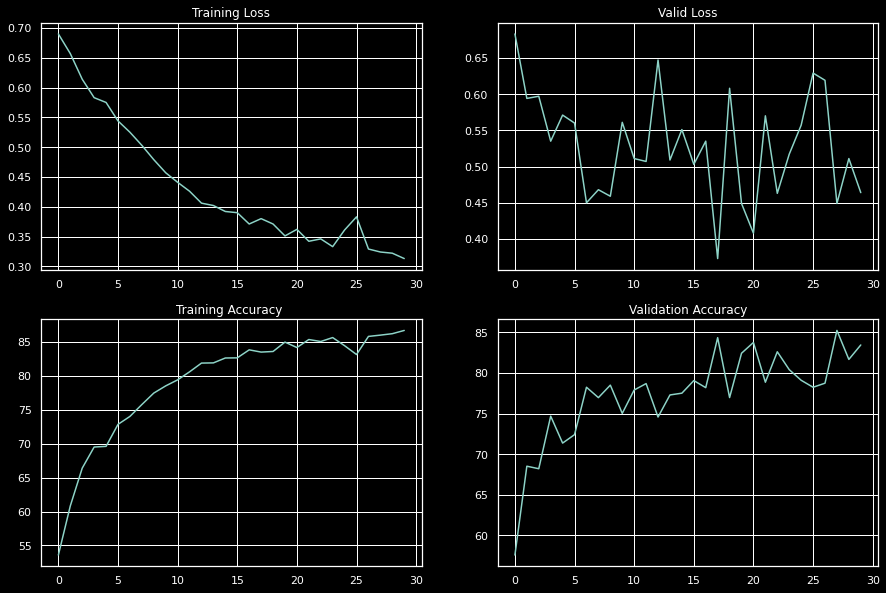

In [97]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_epoch)
axs[0, 0].set_title("Training Loss")
axs[0, 1].plot(valid_loss_epoch)
axs[0, 1].set_title("Valid Loss")
axs[1, 0].plot(train_acc_epoch)
axs[1, 0].set_title("Training Accuracy ")
axs[1, 1].plot(valid_acc_epoch)
axs[1, 1].set_title("Validation Accuracy")

plt.show()

In [98]:
# CALCULATE TEST SET LOSS AND ACCURACY 

In [99]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.377 | Test Acc: 84.48%
